(from https://qiita.com/fukuit/items/b3fa460577a0ea139c88)
## クラス・関数の準備

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
def plot_result(history):
    '''
    plot result
    全ての学習が終了した後に、historyを参照して、accuracyとlossをそれぞれplotする
    '''

    # accuracy
    plt.figure()
    plt.plot(history.history['acc'], label='acc', marker='.')
    plt.plot(history.history['val_acc'], label='val_acc', marker='.')
    plt.grid()
    plt.legend(loc='best')
    plt.title('accuracy')
    plt.savefig('graph_accuracy.png')
    plt.show()

    # loss
    plt.figure()
    plt.plot(history.history['loss'], label='loss', marker='.')
    plt.plot(history.history['val_loss'], label='val_loss', marker='.')
    plt.grid()
    plt.legend(loc='best')
    plt.title('loss')
    plt.savefig('graph_loss.png')
    plt.show()

(from https://qiita.com/fukuit/items/b3fa460577a0ea139c88)

## MNISTのデータをダウンロードしておく
kearsではデータセットとしてMNISTが公開されている。

とりあえず、一旦、データセットだけをダウンロードしておきたいので、ipythonで以下のように実行すると、~/.keras/datasets/にmnist.npzというファイルが保存される。

In [2]:
import keras
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11501568/11490434 [==============================] - 4s 0us/step


これにより、x_trainには60000個の学習用データ、y_trainにはそれに対応するラベル、x_testには10000個のテスト用データと、ソレに対応するラベルであるy_testという変数が、それぞれ作成される。

機械学習の勉強をしていると、必ず「trainingセットとtestセットとvalidationセットは別にしておけよ」と言われると思うんだけれど、これだとtrainingセットとtestセットしかないじゃん。というワケで、trainingセットから、10000個くらいをランダムに選んで、validationセットも作っておくことにする。

In [3]:
from sklearn.model_selection import train_test_split
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.175)

これで、validationセットが10500個できた。

## MNISTをConvolutional Neural Networkで解く
### modelの作成
とりあえず、modelを作る。

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


ちゃんと過学習しないように、Dropout()しておく。

### 学習
学習する。最適化には、RMSprop()を使う。examplesには、Adadelta()を使うって書いてあるんだけれど、なんとなくRMSprop()で。
こういうのの選び方って、鉄則みたいなのあるんですかね。

学習前に、x_train、x_valid、x_test、y_train、y_valid、y_testの前処理をする。

In [5]:
# 28 x 28の画像がgrayscaleで1chなので、28, 28, 1にreshapeする
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# 0-255の整数値を0〜1の小数に変換する
# MNISTって必ずこの処理入るけれど、意味あるのかな
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

# one-hot vector形式に変換する
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10)

前処理が済んだら、学習する。

In [6]:
from keras.optimizers import RMSprop
from keras.callbacks import Callback, CSVLogger

print(model.summary())

batch_size = 128
epochs = 10

# callback function
csv_logger = CSVLogger('./trainlog.csv')

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# train
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[csv_logger])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

学習した結果は、次のようにすると表示できた。
評価は、学習に使っていないx_test、y_testで行う。

('Test loss:', 0.034617060166123335)
('Test accuracy:', 0.9886)


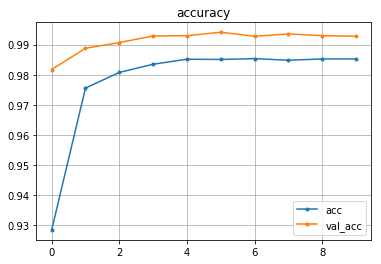

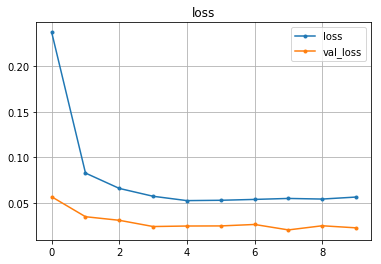

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_result(history)